### Import Library

In [1]:

import cv2
import PIL
from PIL import Image
from PIL import ImageDraw
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import numpy as np
import seaborn as sns
import pandas as pd
import shutil

from tqdm import tqdm
from tqdm.notebook import trange, tqdm
import pytesseract
import re
import seaborn as sns
sns.set_theme()


### deskew 


In [2]:
from deskew import determine_skew


# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = determine_skew(cvImage)
    return rotateImage(cvImage, angle)

Show one Picture

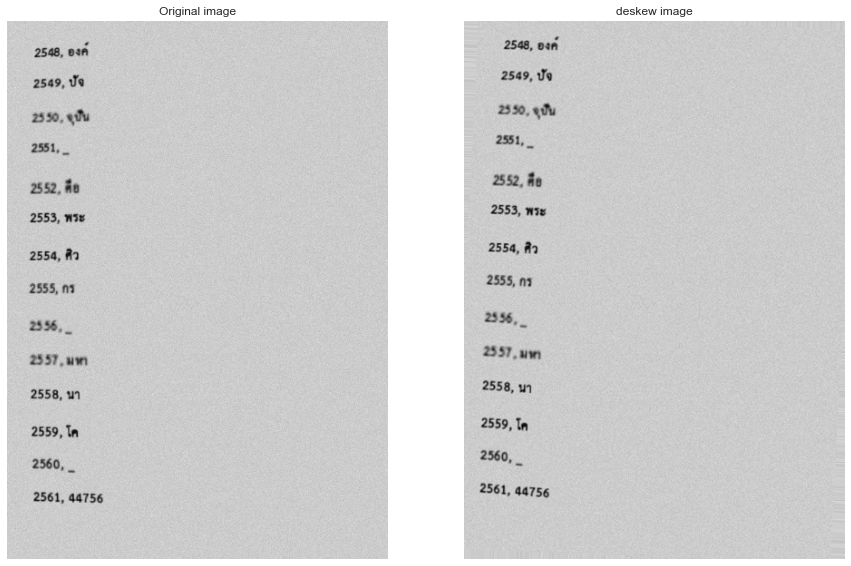

In [8]:

local=r'images\00182.jpg'
img = cv2.imread(local,0)
fixed = deskew(img)



plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1,2,1)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax1.imshow(img)
ax1.axis('off')
plt.title("Original image")


ax2 = plt.subplot(1,2,2)
fixed =cv2.cvtColor(fixed , cv2.COLOR_BGR2RGB)
ax2.imshow(fixed)
ax2.axis('off')
plt.title("deskew image")

plt.show()


# cv2.imshow('orginal', img)
# cv2.imshow('fixed ', fixed )

# cv2.waitKey(0)
# cv2.destroyAllWindows()


Cut picture via detection of Contour

15


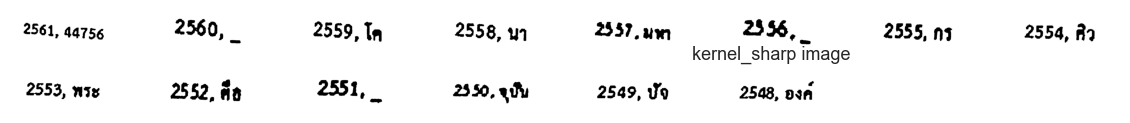

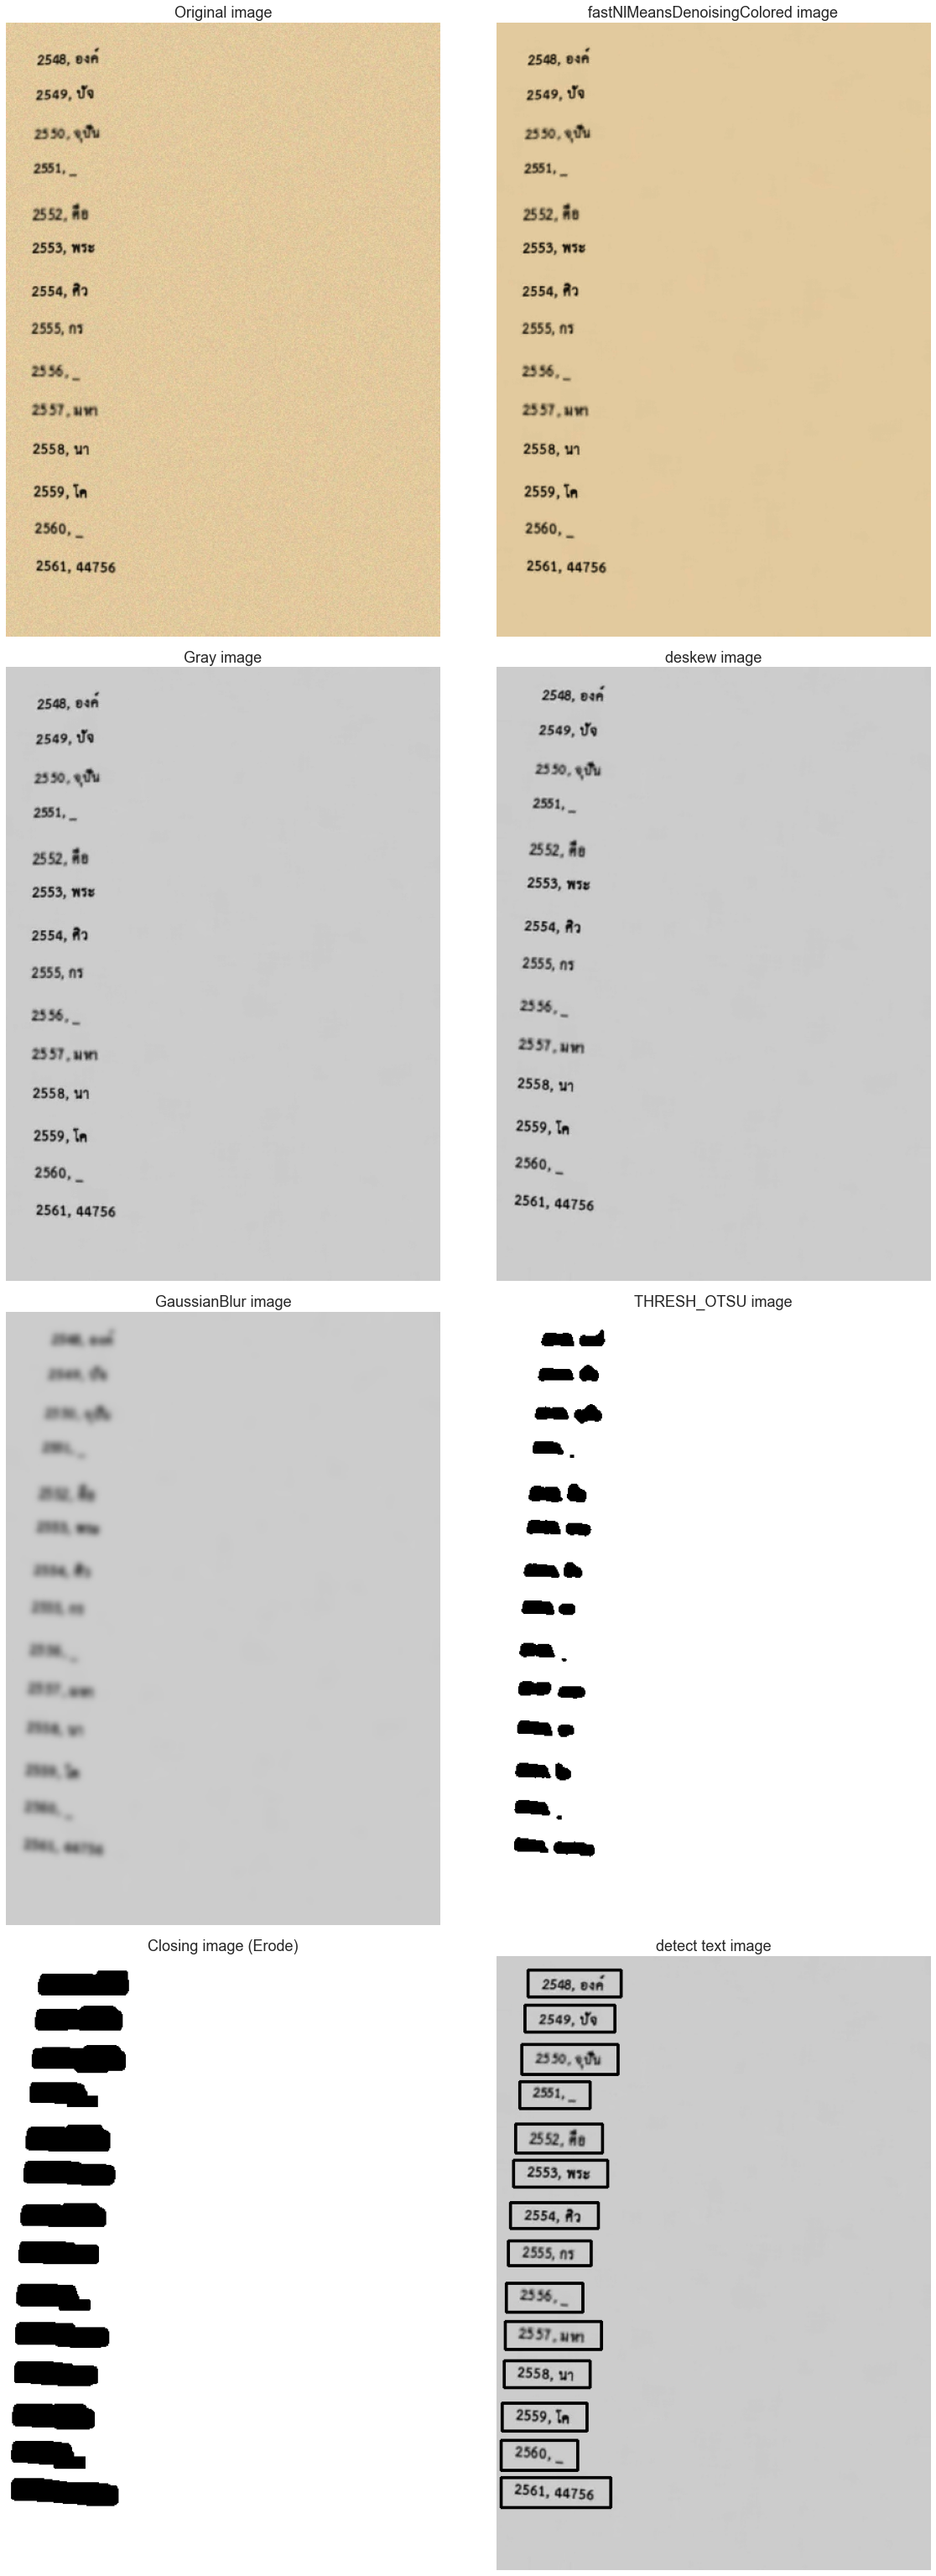

In [15]:
local=r'images\00182.jpg'
imgresize = cv2.imread(local)
#remove noise
dst = cv2.fastNlMeansDenoisingColored(imgresize, None, 5, 5, 7, 21) 
# Grayscale
gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

deskew_ = deskew(gray)
imgresize2 = deskew_.copy()
gray_blur = cv2.GaussianBlur(deskew_,(15,15),0)
thresh=cv2.threshold(gray_blur, 180, 255, cv2.THRESH_BINARY +cv2.THRESH_OTSU)[1]
kernel=np.ones((5,14),np.uint8)
closing = cv2.erode(thresh,kernel,iterations = 2)
result_img=closing.copy()

contours,hierachy=cv2.findContours(result_img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
w,h= result_img.shape
print(len(contours))

kernel_sharp = np.array([[0,-1,0],
                         [-1,5,-1],
                         [0,-1,0]],dtype=np.float32)

plt.figure(figsize=(20, 2))

for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    
    if i != len(contours)-1:
        ax = plt.subplot(2,8,i+1)
        (x,y,w,h)= cv2.boundingRect(cnt)
        result = imgresize2[y-3:y+h+3,x-2:x+w+5]
        h_,w_ = result.shape
        result = cv2.filter2D(result,-1,kernel_sharp) 
        result = cv2.fastNlMeansDenoising(result, None, 20, 7, 21)
        result = cv2.resize(result, (w_*8,h_*8), interpolation = cv2.INTER_AREA)
       

        result = cv2.GaussianBlur(result,(11,11),0)
        result=cv2.threshold(result,180,255,cv2.THRESH_OTSU)[1]

        kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT,(1,1))
        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT,(1,1))

        
        result = cv2.erode(result,kernel2,iterations = 1)
        result =cv2.dilate(result,kernel3,iterations = 10)
        

        result =cv2.morphologyEx(result,cv2.MORPH_OPEN,kernel2,iterations=5)
        #result =cv2.morphologyEx(result,cv2.MORPH_CLOSE,kernel2,iterations=4)
        

        cv2.imwrite('image_cut3/{}.jpg'.format(i),result)
       
        #forplot 
        result=cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        ax.imshow(result)
        ax.axis('off')
        cv2.rectangle(imgresize2,(x,y),(x+w,y+h),(0,0,255),2)

ax.text(-180,-80, 'kernel_sharp image',fontsize=18 )      


plt.figure(figsize=(20, 70))

def plot_step(img,n,text='image') :

    ax1 = plt.subplot(5,2,n)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax1.imshow(img)
    ax1.axis('off')
    plt.title(text,fontsize=18)

plot_step(imgresize,1,text="Original image") 
plot_step(dst,2,text="fastNlMeansDenoisingColored image")  
plot_step(gray,3,text="Gray image")     
plot_step(deskew_,4,text="deskew image")     
plot_step(gray_blur,5,text="GaussianBlur image")     
plot_step(thresh,6,text="THRESH_OTSU image")  
plot_step(closing,7,text="Closing image (Erode)")  
plot_step(imgresize2,8,text="detect text image")  
plt.subplots_adjust(wspace=0.10, hspace=0.05)
plt.show()






### Cut image (Auto) save in folder 'image_cut'

In [ ]:
path_image_cut= 'image_cut4'
path_image = 'images'
try: shutil.rmtree(path_image_cut)
except : pass
#Create Folder
os.mkdir(path_image_cut)


kernel_sharp = np.array([[0,-1,0],
                   [-1,5,-1],
                   [0,-1,0]],dtype=np.float32)

num=0
for index in tqdm(range(len(os.listdir(path_image)))): 
    imgresize = cv2.imread(path_image+'/'+os.listdir(path_image)[index])
    #remove noise
    dst = cv2.fastNlMeansDenoisingColored(imgresize, None, 5, 5, 7, 21) 
    # Grayscale
    gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    deskew_ = deskew(gray)
    imgresize2 = deskew_
    gray_blur = cv2.GaussianBlur(deskew_,(15,15),0)
    thresh=cv2.threshold(gray_blur, 180, 255, cv2.THRESH_BINARY +cv2.THRESH_OTSU)[1]
    kernel=np.ones((5,14),np.uint8)
    closing = cv2.erode(thresh,kernel,iterations = 2)
    result_img=closing.copy()

    contours,hierachy=cv2.findContours(result_img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    w,h= result_img.shape
    print(len(contours),index)
    num=14*(index+1)-1
    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if i != len(contours)-1:
            (x,y,w,h)= cv2.boundingRect(cnt)
            result = imgresize2[y-3:y+h+3,x-2:x+w+5]
            h_,w_ = result.shape
            
            result = cv2.filter2D(result,-1,kernel_sharp) 
            result = cv2.fastNlMeansDenoising(result, None, 20, 7, 21)
            result = cv2.resize(result, (w_*8,h_*8), interpolation = cv2.INTER_AREA)
            result = cv2.GaussianBlur(result,(11,11),0)
            result=cv2.threshold(result,180,255,cv2.THRESH_OTSU)[1]
            kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT,(1,1))
            result =cv2.morphologyEx(result,cv2.MORPH_OPEN,kernel2,iterations=5)
            
            cv2.imwrite(path_image_cut+'/{}.jpg'.format(num),result)
            num-=1
            
        


### Pytesseract 

In [18]:
import pytesseract
print(pytesseract.get_tesseract_version())
print(pytesseract.get_languages())

5.2.0.20220712
 leptonica-1.78.0
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.5.3) : libpng 1.6.34 : libtiff 4.0.9 : zlib 1.2.11 : libwebp 0.6.1 : libopenjp2 2.3.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.5.0 zlib/1.2.11 liblzma/5.2.3 bz2lib/1.0.6 liblz4/1.7.5 libzstd/1.4.5
 Found libcurl/7.77.0-DEV Schannel zlib/1.2.11 zstd/1.4.5 libidn2/2.0.4 nghttp2/1.31.0

['eng', 'equ', 'osd', 'tha']


Create fuction to postprocess

In [66]:


list_num = [str(x) for x in range(1000)]
def clean_data(txt,j):
    txt=txt.replace('\n','')
    txt=txt.replace('|','')
    
    if ","  in txt:
        txt=txt[txt.index(',')+1:]
    elif '.' in txt:
        txt=txt[txt.index('.')+1:]
    elif ' ' in txt :
        txt=txt[txt.index(' ')+1:]
    elif ':' in txt :
        txt=txt[txt.index(':')+1:]
        
    elif str(j) in txt :
        txt=txt[txt.index(str(j))+1:]

    txt=txt.replace(' ','')
    txt=txt.replace('-','')
    txt=txt.replace('๕','&')
   
    

    text=re.findall("[ก-๙]+", txt)
    num=re.findall("[0-9]+", txt)
    if (len(text) == len(num) != 0)  :
        txt=text[0] 
    elif len(text) ==0 and len(num) >0 :
        if str(j) not in txt :
            txt=num[0]
        else : txt= '_' 

    if txt == '':
        txt ='_'
    return txt


Test with one pic to image

In [20]:
def plot_step2(local,text='image') :
    img = cv2.imread(local)
    ax1 = plt.subplot(1,1,1)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax1.imshow(img)
    ax1.axis('off')
    plt.title(text,fontsize=18)
    plt.show()

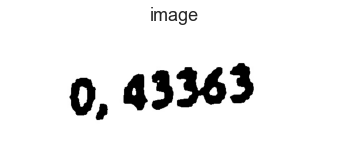

43363
output : 43363


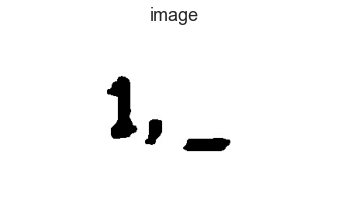

_
output : _


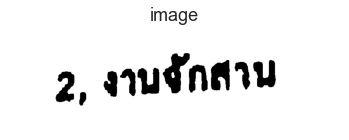

งานจักสาน
output : งานจักสาน


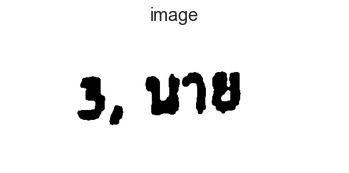

นาย
output : นาย


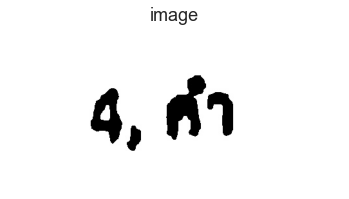

คํา
output : คํา


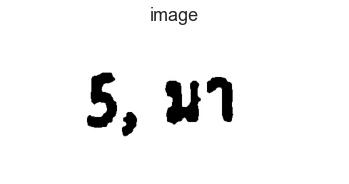

นา
output : นา


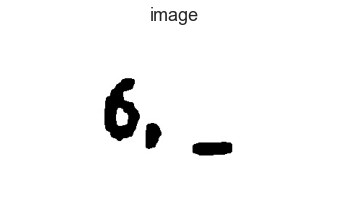

_
output : _


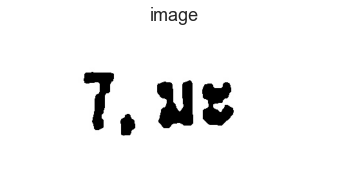

มะ
output : มะ


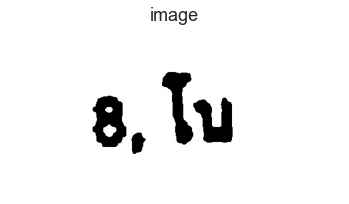

ใบ
output : ใบ


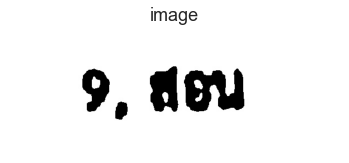

_
output : _


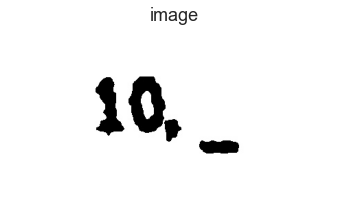

_
output : _


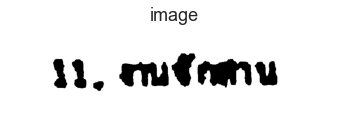

งานจักดาน
output : งานจักดาน


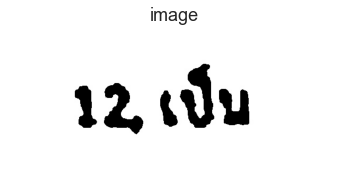

เป็น
output : เป็น


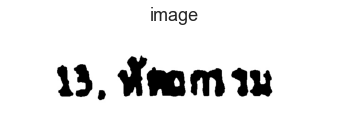

หัตอกางน
output : หัตอกางน


In [65]:
n=0
n+=1
for j in range(14*n-14,14*n,1):
    local = r'image_cut4\{}.jpg'.format(j)
    img = Image.open(local)
    txt = pytesseract.image_to_string(local, lang='tha',config='--oem 3') # --psm 13 --psm 8
    # txt2 = pytesseract.image_to_string(local, lang='tha+eng',config='--oem 3') # --psm 13 --psm 8
    # txt3 = pytesseract.image_to_string(local, lang='eng',config='--oem 3') # --psm 13 --psm 8
    

    txt= clean_data(txt,j)
    # txt2= clean_data(txt2,j)
    # txt3= clean_data(txt3,j)
    
    plot_step2(local)
    print(txt)
    print("output :",txt )
    # print("Thai : ",txt)
    # print("Thai+Eng : ",txt2)
    # print("Eng : ",txt3)
    # if len(txt) > (len(txt2)):
    #     print("output :",txt )
    # elif len(txt) == (len(txt2)) :
    #     if txt2==txt3 :
    #         print("output :",txt2 )
    #     else :
    #         print("output :",txt )
    # else :
    #     print("output :",txt2 )
   

Create DataFrame and check number of image

In [67]:
df_test = pd.DataFrame({"Id" : [], "Text" : []})
path_image_cut= 'image_cut2'
image_list = os.listdir(path_image_cut)
print(len(image_list))

14000


### Using pytesseract read Text and postprocess with custom fuction then save texts into Dataframe

In [ ]:
path_image_cut= 'image_cut4'
image_list = os.listdir(path_image_cut)
print(len(image_list))
for i in trange(0,14000,1):
    local = path_image_cut+'/{}.jpg'.format(i)
    txt = pytesseract.image_to_string(local, lang='tha',config='--oem 3') # --psm 13 --psm 8
    txt= clean_data(txt,j)
    df_test=df_test.append({"Id" : i, "Text" : txt}, ignore_index=True)

In [69]:
df_test

,Id,Text
0,0.0,43363
1,1.0,_
2,2.0,งานจักสาน
3,3.0,นาย
4,4.0,คํา
...,...,...
13995,13995.0,ปราบ
13996,13996.0,.
13997,13997.0,@
13998,13998.0,4


In [70]:
df_new=df_test.copy()
df_new['Id']=df_new['Id'].astype(int)
df_new=df_new.sort_values(by=['Id'])
df_new=df_new.reset_index(drop=True)

In [71]:
df_new

,Id,Text
0,0,43363
1,1,_
2,2,งานจักสาน
3,3,นาย
4,4,คํา
...,...,...
13995,13995,ปราบ
13996,13996,.
13997,13997,@
13998,13998,4


Save DataFrame and bring it into Bert-Transformer (NLP) 

In [72]:
df_new.to_csv('df_test_new-BW.csv',index=False)

NER tag for maping with Culture dataset

In [ ]:
NER_TAGS = {
        "O"     :  18   ,
        "B_BRN" :   8   ,
        "B_DES" :  12   ,
        "B_DTM" :   0   ,
        "B_LOC" :   2   ,
        "B_MEA" :   4   ,
        "B_NUM" :   6   ,
        "B_ORG" :   10  ,
        "B_PER" :   12  ,
        "B_TRM" :   18  ,
        "B_TTL" :   12  ,
        "I_BRN" :   9   ,
        "I_DES" :   13  ,
        "I_DTM" :   1   ,
        "I_LOC" :   3   ,
        "I_MEA" :   5   ,
        "I_NUM" :   7   ,
        "I_ORG" :   11  ,
        "I_PER" :  13   ,
        "I_TRM" :  18   ,
        "I_TTL" :  13   ,
        "E_BRN" :   9   ,
        "E_DES" :   13  ,
        "E_DTM" :   1   ,
        "E_LOC" :   3   ,
        "E_MEA" :   5   ,
        "E_NUM" :   7   ,
        "E_ORG" :   11  ,
        "E_PER" :   13  ,
        "E_TRM" :   18  ,  
}